In [ ]:
pip install dbnomics pandas matplotlib seaborn

In [ ]:
# %% [code] - RELATÓRIO COMPLETO
import pandas as pd
import numpy as np
from dbnomics import fetch_series
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configurações de estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
figsize = (14, 6)

# === 1. MAPEAMENTO DAS SÉRIES ===
series_mapping = {
    'Alumínio': 'M.CIMP.36.VALEUR_ABSOLUE.NOUVEAU.ETR.USD.BRUT.0048.SO.SO.FALSE',
    'Zinco': 'M.CIMP.38.VALEUR_ABSOLUE.NOUVEAU.ETR.USD.BRUT.0048.SO.SO.FALSE',
    'Prata': 'M.CIMP.46.VALEUR_ABSOLUE.NOUVEAU.ETR.USD.BRUT.0151.SO.SO.FALSE',  # centavos/oz
    'Ouro': 'M.CIMP.56.VALEUR_ABSOLUE.NOUVEAU.ETR.USD.BRUT.0048.SO.SO.FALSE',
    'Cobre': 'M.CIMP.70.VALEUR_ABSOLUE.NOUVEAU.ETR.USD.BRUT.0048.SO.SO.FALSE',
    'Níquel': 'M.CIMP.71.VALEUR_ABSOLUE.NOUVEAU.ETR.USD.BRUT.0048.SO.SO.FALSE',
    'Chumbo': 'M.CIMP.72.VALEUR_ABSOLUE.NOUVEAU.ETR.USD.BRUT.0048.SO.SO.FALSE',
    'Estanho': 'M.CIMP.81.VALEUR_ABSOLUE.NOUVEAU.ETR.USD.BRUT.0048.SO.SO.FALSE',
    'Cobalto': 'M.CIMP.93.VALEUR_ABSOLUE.NOUVEAU.ETR.USD.BRUT.0048.SO.SO.FALSE',
    'Molibdênio': 'M.CIMP.95.VALEUR_ABSOLUE.NOUVEAU.ETR.USD.BRUT.0048.SO.SO.FALSE'
}

# === 2. DOWNLOAD E TRATAMENTO ===
all_data = []
for name, code in series_mapping.items():
    try:
        df = fetch_series('INSEE', 'IPPMP-NF', code)
        df = df[['period', 'value']].copy()
        df['series_name'] = name
        df['period'] = pd.to_datetime(df['period'])
        all_data.append(df)
    except: pass

df_raw = pd.concat(all_data).sort_values(['period', 'series_name']).reset_index(drop=True)

# Ajuste Prata: centavos → USD/oz
df_raw.loc[df_raw['series_name'] == 'Prata', 'value'] = df_raw.loc[df_raw['series_name'] == 'Prata', 'value'] / 100

# Pivot
df = df_raw.pivot(index='period', columns='series_name', values='value')

ERROR:dbnomics:Finished call to 'dbnomics._fetch_response' after 0.651(s), this was the 1st time calling it.
ERROR:dbnomics:Finished call to 'dbnomics._fetch_response' after 1.223(s), this was the 2nd time calling it.
ERROR:dbnomics:Finished call to 'dbnomics._fetch_response' after 2.932(s), this was the 3rd time calling it.
ERROR:dbnomics:Finished call to 'dbnomics._fetch_response' after 0.490(s), this was the 1st time calling it.
ERROR:dbnomics:Finished call to 'dbnomics._fetch_response' after 1.813(s), this was the 2nd time calling it.
ERROR:dbnomics:Finished call to 'dbnomics._fetch_response' after 3.421(s), this was the 3rd time calling it.
ERROR:dbnomics:Finished call to 'dbnomics._fetch_response' after 0.497(s), this was the 1st time calling it.
ERROR:dbnomics:Finished call to 'dbnomics._fetch_response' after 1.800(s), this was the 2nd time calling it.
ERROR:dbnomics:Finished call to 'dbnomics._fetch_response' after 2.881(s), this was the 3rd time calling it.


In [ ]:
# === 3. MÉTRICAS PRINCIPAIS ===
latest = df.iloc[-1]
yoy = ((df.iloc[-1] / df.iloc[-13]) - 1) * 100 if len(df) >= 13 else pd.Series()
ytd = ((df.iloc[-1] / df.loc[df.index.year == df.index[-1].year].iloc[0]) - 1) * 100
vol_12m = df.pct_change().rolling(12).std().iloc[-1] * np.sqrt(12) * 100

metrics = pd.DataFrame({
    'Preço Atual': latest.round(2),
    'Var. 12M (%)': yoy.round(1),
    'Var. YTD (%)': ytd.round(1),
    'Vol. Anual (%)': vol_12m.round(1)
}).sort_values('Var. 12M (%)', ascending=False)

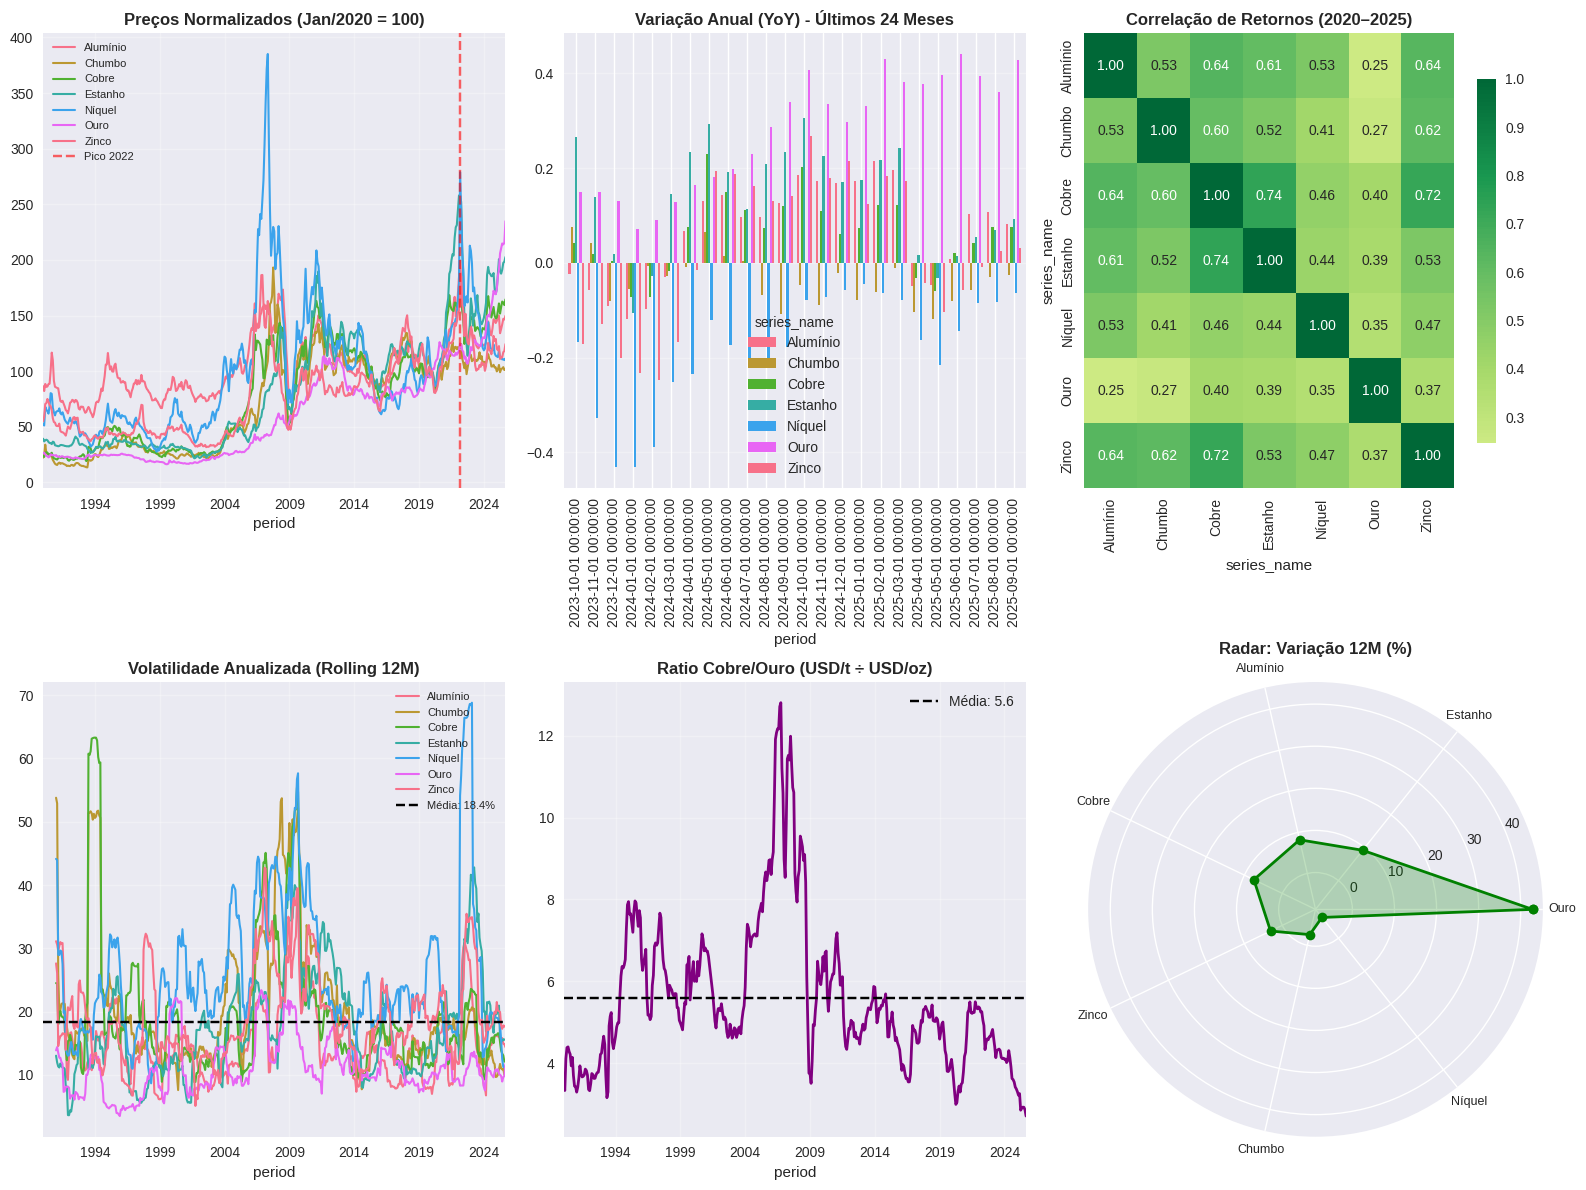

In [ ]:
# === 4. VISUALIZAÇÕES ===
fig = plt.figure(figsize=(16, 12))

# 4.1 Preços Normalizados (2020 = 100)
ax1 = plt.subplot(2, 3, 1)
df_norm = df.div(df.loc['2020-01-01']) * 100
df_norm.plot(ax=ax1, linewidth=1.5)
ax1.set_title('Preços Normalizados (Jan/2020 = 100)', fontsize=12, fontweight='bold')
ax1.axvline('2022-03-01', color='red', linestyle='--', alpha=0.6, label='Pico 2022')
ax1.legend(fontsize=8, loc='upper left')
ax1.grid(True, alpha=0.3)

# 4.2 Variação Anual (YoY)
ax2 = plt.subplot(2, 3, 2)
yoy_plot = df.pct_change(12).iloc[-24:]
yoy_plot.plot(kind='bar', ax=ax2, width=0.8)
ax2.set_title('Variação Anual (YoY) - Últimos 24 Meses', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# 4.3 Heatmap de Correlação (2020–2025)
ax3 = plt.subplot(2, 3, 3)
corr = df.loc['2020':].pct_change().corr()
sns.heatmap(corr, annot=True, cmap='RdYlGn', center=0, ax=ax3, fmt='.2f', cbar_kws={'shrink': 0.8})
ax3.set_title('Correlação de Retornos (2020–2025)', fontsize=12, fontweight='bold')

# 4.4 Volatilidade Rolling 12M
ax4 = plt.subplot(2, 3, 4)
vol = df.pct_change().rolling(12).std() * np.sqrt(12) * 100
vol.plot(ax=ax4, linewidth=1.5)
ax4.set_title('Volatilidade Anualizada (Rolling 12M)', fontsize=12, fontweight='bold')
ax4.axhline(vol.mean().mean(), color='black', linestyle='--', label=f'Média: {vol.mean().mean():.1f}%')
ax4.legend(fontsize=8)
ax4.grid(True, alpha=0.3)

# 4.5 Cobre vs. Ouro (Ratio)
ax5 = plt.subplot(2, 3, 5)
ratio = df['Cobre'] / df['Ouro']
ratio.plot(ax=ax5, color='purple', linewidth=2)
ax5.set_title('Ratio Cobre/Ouro (USD/t ÷ USD/oz)', fontsize=12, fontweight='bold')
ax5.axhline(ratio.mean(), color='black', linestyle='--', label=f'Média: {ratio.mean():.1f}')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 4.6 Radar Chart (Performance Relativa)
ax6 = plt.subplot(2, 3, 6, projection='polar')
categories = metrics.index
values = metrics['Var. 12M (%)'].values
values = np.append(values, values[0])
angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]
ax6.plot(angles, values, 'o-', linewidth=2, color='green')
ax6.fill(angles, values, alpha=0.25, color='green')
ax6.set_xticks(angles[:-1])
ax6.set_xticklabels(categories, fontsize=9)
ax6.set_title('Radar: Variação 12M (%)', fontsize=12, fontweight='bold', pad=20)
ax6.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# === 5. TABELAS DE INSIGHTS ===
print("\n" + "="*60)
print("TOP 3 EM ALTA (12M)")
print(metrics.head(3)[['Preço Atual', 'Var. 12M (%)']])
print("\nTOP 3 EM BAIXA (12M)")
print(metrics.tail(3).sort_values('Var. 12M (%)')[['Preço Atual', 'Var. 12M (%)']])

print("\n" + "="*60)
print("INDICADORES ESTRUTURAIS")
print(f"• Cobre/Ouro Ratio: {ratio.iloc[-1]:.2f} (média histórica: {ratio.mean():.2f})")
print(f"• Volatilidade Média (5Y): {vol.loc['2020':].mean().mean():.1f}%")
print(f"• Correlação Cobre x Ouro: {corr.loc['Cobre', 'Ouro']:.2f} (baixa = diversificação)")


TOP 3 EM ALTA (12M)
             Preço Atual  Var. 12M (%)
series_name                           
Ouro              3665.2          42.8
Estanho          34523.2           9.2
Alumínio          2652.6           8.2

TOP 3 EM BAIXA (12M)
             Preço Atual  Var. 12M (%)
series_name                           
Níquel           15093.2          -6.3
Chumbo            1954.0          -2.6
Zinco             2929.0           3.1

INDICADORES ESTRUTURAIS
• Cobre/Ouro Ratio: 2.72 (média histórica: 5.59)
• Volatilidade Média (5Y): 18.5%
• Correlação Cobre x Ouro: 0.40 (baixa = diversificação)
